<a href="https://colab.research.google.com/github/Anik-1802021/ML-Autoencoder-denoise-custom-dataset/blob/main/Denoise_Autoencoder_custom_dataset_v_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
29/29 [==============================] - 284s 10s/step - loss: 0.4417 - val_loss: 0.3983
Epoch 2/10
29/29 [==============================] - 272s 9s/step - loss: 0.4015 - val_loss: 0.3770
Epoch 3/10
29/29 [==============================] - 275s 9s/step - loss: 0.3895 - val_loss: 0.3731
Epoch 4/10
29/29 [==============================] - 272s 9s/step - loss: 0.3871 - val_loss: 0.3712
Epoch 5/10
29/29 [==============================] - 277s 10s/step - loss: 0.3856 - val_loss: 0.3699
Epoch 6/10
29/29 [==============================] - 272s 9s/step - loss: 0.3843 - val_loss: 0.3688
Epoch 7/10
29/29 [==============================] - 272s 9s/step - loss: 0.3834 - val_loss: 0.3679
Epoch 8/10
29/29 [==============================] - 274s 9s/step - loss: 0.3824 - val_loss: 0.3673
Epoch 9/10
29/29 [==============================] - 273s 9s/step - loss: 0.3817 - val_loss: 0.3668
Epoch 10/10
29/29 [==============================] - 274s 9s/step - loss: 0.3811 - val_loss: 0.3662


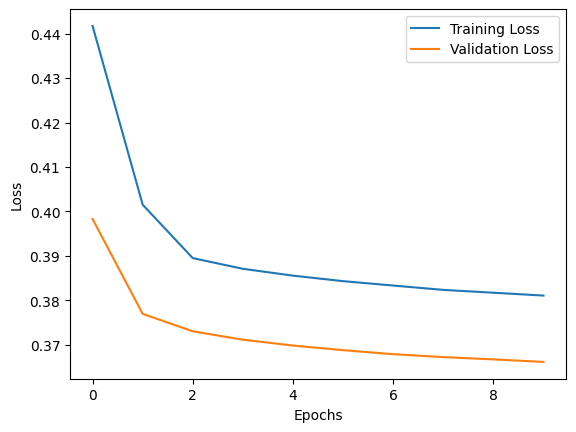

4/4 [==============================] - 20s 4s/step


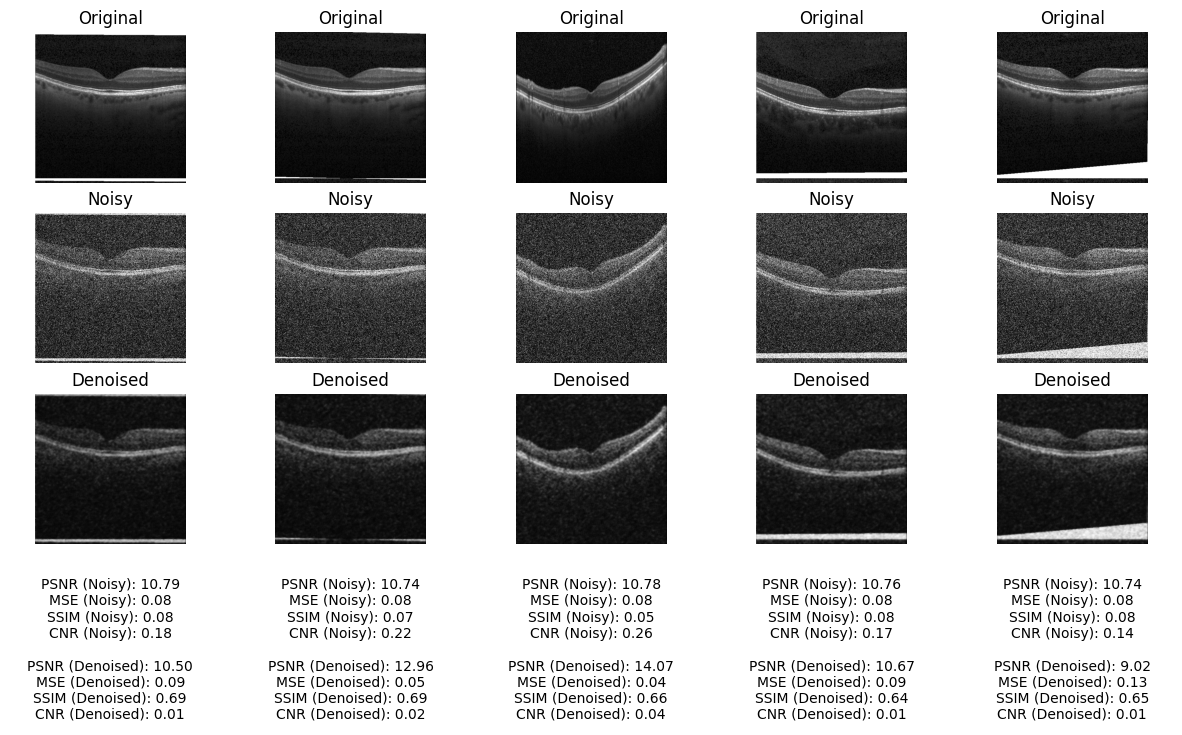

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
import cv2
from skimage.metrics import structural_similarity as ssim

# Function to calculate PSNR
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # As the pixel values are normalized to [0, 1]
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

# Function to calculate MSE
def mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

# Function to calculate SSIM
def calculate_ssim(img1, img2):
    img1 = img1.squeeze()  # Remove channel dimension for SSIM calculation
    img2 = img2.squeeze()
    ssim_value, _ = ssim(img1, img2, full=True)
    return ssim_value

# Function to calculate CNR (simple implementation)
def calculate_cnr(img1, img2):
    mean1, std1 = cv2.meanStdDev(img1)
    mean2, std2 = cv2.meanStdDev(img2)
    cnr_value = abs(mean1 - mean2) / (std1 + std2)
    return cnr_value[0][0]

# Function to load and preprocess images
def load_images_from_folder(folder, image_size=(512, 512)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = plt.imread(img_path, format='grayscale')  # Load image in grayscale
            img = img / 255.0  # Normalize pixel values to [0, 1]
            img = img.astype('float32')
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            img = np.resize(img, image_size)  # Resize image to specified dimensions
            images.append(img)
    images = np.array(images)
    return images

# Load images from the specified dataset folder
dataset_folder = '/content/drive/MyDrive/Thesis/Swin Transformer /custom_dataset/train/NORMAL'
image_size = (512, 512)
images = load_images_from_folder(dataset_folder, image_size)

# Split data into training and test sets
x_train = images[:int(0.8 * len(images))]
x_test = images[int(0.8 * len(images)):]

# Add noise to the data
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Define the denoising autoencoder model
def denoising_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1)
    # Decoder
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    up1 = UpSampling2D((2, 2))(conv2)
    # Output
    outputs = Conv2D(1, (3, 3), activation='LeakyReLU', padding='same')(up1)
    model = Model(inputs, outputs)
    return model

# Create and compile the denoising autoencoder model
input_shape = (image_size[0], image_size[1], 1)
denoise_model = denoising_autoencoder(input_shape)
denoise_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history = denoise_model.fit(x_train_noisy, x_train, epochs=10, batch_size=16, validation_data=(x_test_noisy, x_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict on test data
denoised_images = denoise_model.predict(x_test_noisy)

# Display original, noisy, and denoised images
n = 5
plt.figure(figsize=(15, 9))
for i in range(n):
    # Original Image
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[i].reshape(image_size), cmap='gray')
    ax.set_title('Original')
    ax.axis('off')
    # Noisy Image
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(image_size), cmap='gray')
    ax.set_title('Noisy')
    ax.axis('off')
    # Denoised Image
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(image_size), cmap='gray')
    ax.set_title('Denoised')
    ax.axis('off')
    # Metrics
    psnr_noisy = psnr(x_test[i], x_test_noisy[i])
    mse_noisy = mse(x_test[i], x_test_noisy[i])
    ssim_noisy = calculate_ssim(x_test[i], x_test_noisy[i])
    cnr_noisy = calculate_cnr(x_test[i], x_test_noisy[i])

    psnr_denoised = psnr(x_test[i], denoised_images[i])
    mse_denoised = mse(x_test[i], denoised_images[i])
    ssim_denoised = calculate_ssim(x_test[i], denoised_images[i])
    cnr_denoised = calculate_cnr(x_test[i], denoised_images[i])

    ax = plt.subplot(4, n, i + 1 + 3*n)
    metrics_text = f"PSNR (Noisy): {psnr_noisy:.2f}\nMSE (Noisy): {mse_noisy:.2f}\nSSIM (Noisy): {ssim_noisy:.2f}\nCNR (Noisy): {cnr_noisy:.2f}\n\nPSNR (Denoised): {psnr_denoised:.2f}\nMSE (Denoised): {mse_denoised:.2f}\nSSIM (Denoised): {ssim_denoised:.2f}\nCNR (Denoised): {cnr_denoised:.2f}"
    plt.text(0.5, 0.5, metrics_text, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.axis('off')
plt.show()
